In [1]:
import json

pp_2_ev_path = "/home/squirrel/ccg-new/projects/perspective/data/pilot3_twowingos/pp_2_ev_20181105.json" 
ev_2_pp_path = "/home/squirrel/ccg-new/projects/perspective/data/pilot3_twowingos/ev_2_pp_20181105.json" 

with open(pp_2_ev_path) as fin, open(ev_2_pp_path) as fin2:
    pp_2_ev = json.load(fin)
    ev_2_pp = json.load(fin2)

In [1]:
# 1109 update: wenpeng retrained the system

import json

pp_2_ev_path = "/home/squirrel/ccg-new/projects/perspective/data/pilot3_twowingos/pp_2_ev_20181109.json" 
ev_2_pp_path = "/home/squirrel/ccg-new/projects/perspective/data/pilot3_twowingos/ev_2_pp_20181109.json" 

with open(pp_2_ev_path) as fin, open(ev_2_pp_path) as fin2:
    pp_2_ev = json.load(fin)
    ev_2_pp = json.load(fin2)

In [2]:
import pandas as pd

evidence_rel_path = "/home/squirrel/ccg-new/projects/perspective/data/database_output/webapp_evidencerelation.csv"
evidence_path = "/home/squirrel/ccg-new/projects/perspective/data/database_output/webapp_evidence.csv"
persp_path = "/home/squirrel/ccg-new/projects/perspective/data/database_output/webapp_perspective.csv"

df = pd.read_csv(evidence_rel_path)
df.info()

edf = pd.read_csv(evidence_path)
pdf = pd.read_csv(persp_path)

def get_gold_persp(evidence_id):
    q = df.loc[df.evidence_id == evidence_id]
    if len(q) > 0:
        return q.iloc[0].perspective_id
    else:
        return None
    
def get_gold_evidence(perspective_id):
    q = df.loc[df.perspective_id == perspective_id]
    if len(q) > 0:
        return q.iloc[0].evidence_id
    else:
        return None

def get_persp_text(persp_id):
    q = pdf.loc[pdf.id == persp_id]
    if len(q) > 0:
        return q.iloc[0].title
    else:
        return None
    
def get_evidence_text(evidence_id):
    q = edf.loc[edf.id == evidence_id]
    if len(q) > 0:
        return q.iloc[0].content
    else:
        return None
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8122 entries, 0 to 8121
Data columns (total 5 columns):
id                8122 non-null int64
author            8122 non-null object
perspective_id    8122 non-null int64
evidence_id       8122 non-null int64
comment           0 non-null float64
dtypes: float64(1), int64(3), object(1)
memory usage: 317.3+ KB


In [3]:
# Filter out candidates that are "unsure" as annotated by human
persp_iaa_path = "/home/squirrel/ccg-new/projects/perspective/data/pilot1_persp_verification/persp_iaa.csv"

iaa_df = pd.read_csv(persp_iaa_path)
iaa_df.info()

no_unsure_df = iaa_df[iaa_df["not sure (scaled)"] <= 1]

sup_und_persp_set = set(no_unsure_df.perspective.unique())
len(sup_und_persp_set)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8135 entries, 0 to 8134
Data columns (total 10 columns):
claim                   8135 non-null int64
perspective             8135 non-null int64
sup                     8135 non-null int64
und                     8135 non-null int64
ns                      8135 non-null int64
suporting (scaled)      8135 non-null float64
undermining (scaled)    8135 non-null float64
not sure (scaled)       8135 non-null float64
P_i                     8135 non-null float64
Total                   8135 non-null int64
dtypes: float64(4), int64(6)
memory usage: 635.6 KB


6825

In [4]:
# For each evidence, measure top k accuracy of perspective candidates
k = [1, 40, 100, 1000]
correct = [0 for _k in k]

for e2p in ev_2_pp:
    gold_pp_id = get_gold_persp(e2p['ev_id'])
    for idx, _k in enumerate(k):
        cands = [p for p in e2p['pp_id_list'] if p in sup_und_persp_set]
        
        if gold_pp_id in cands[:_k]:
            correct[idx] += 1

total = len(ev_2_pp)


for idx, _k in enumerate(k):
    print("Top {} accuracy: {}".format(_k, correct[idx] / total))

Top 1 accuracy: 0.11918246737256834
Top 40 accuracy: 0.41812361487318395
Top 100 accuracy: 0.4683575474021177
Top 1000 accuracy: 0.5177296232455061


In [5]:
# Measure average rank of perspective candidates for every evidence (rank starts from 1)
total = len(ev_2_pp)
total_rank = 0

for e2p in ev_2_pp:
    gold_pp_id = get_gold_persp(e2p['ev_id'])
    if gold_pp_id:
        try:
            cands = [p for p in e2p['pp_id_list'] if p in sup_und_persp_set]
            total_rank += cands.index(gold_pp_id) + 1
        except ValueError:
            continue
            
print("Mean Rank of evidence candidates = {}".format(total_rank / total))

Mean Rank of evidence candidates = 38.20019699581384


In [6]:
# Hmm things look bad.. Let's look at some specific examples.

# First, worst cases -- check some examples with rank > 1000
rank_th = 2000
example_count = 5
k = 10

for e2p in ev_2_pp:
    cands = [p for p in e2p['pp_id_list'] if p in sup_und_persp_set]
    gold_pp_id = get_gold_persp(e2p['ev_id'])
    if gold_pp_id:
        try:
            if cands.index(gold_pp_id) >= rank_th:
                print("evidence_id =  {}".format(e2p['ev_id']))
                print("evidence_text =  {}".format(get_evidence_text(e2p['ev_id'])))
                print("gold_persp_id =  {}".format(gold_pp_id))
                print("gold_persp_text =  {}".format(get_persp_text(gold_pp_id)))
                      
                for pid in cands[:k]:
                    print("persp_cand_id =  {}".format(pid))
                    print("persp_cand_text =  {}".format(get_persp_text(pid)))
                
                example_count -= 1
                if example_count <= 0:
                    break
        except ValueError:
            continue
            
        

evidence_id =  2249
evidence_text =  In terms of moral absolutes, killing people is wrong sets the bar fairly low. Pretty much all societies have accepted this as a line that cannot be crossed without the explicit and specific agreement of the state which only happens in very rare circumstances such as in times of war. There is a simple reason for a blanket ban. It allows for no caveats, no misunderstandings, no fudging of the issue, and no shades of grey. Again, the reason for this approach is equally simple; anything other than such a clear cut approach will inevitably be abused [i] . As things stand guilt in the case of murder is determined entirely on the basis that it is proven that someone took another life. Their reasons for doing so may be reflected in sentencing but the court is not required to consider whether someone was justified in killing another. It is in the nature of a court case that it happens after the event and nobody other than the murderer and the deceased know w

evidence_id =  3934
evidence_text =  If there were not already easy access to the book through the Internet [i] , then it might be possible to argue that there was some practical purpose to be served by continuing its suppression. However, when any disaffected teenager can gain easy access to the text while sitting alone in their bedroom, it seems foolish that it cannot also be examined in the cooler light of their history class. The issue is not access to the text; it’s not even really about ownership of the book – both of which are already possible – but rather about how the book is treated. Not publishing or using the book up until now has simply maintained a situation that was put in place after WWII, which in some ways served a purpose, of saying there was no particular reason for a change at any particular time during that process. However, as the seventieth anniversary of the end of the war comes into view, it seems reasonable that the book should be treated as exactly what it i

In [8]:
# Next, best cases -- check some examples with rank < 10
rank_th = 5
example_count = 5
k = 10

for e2p in ev_2_pp:
    cands = [p for p in e2p['pp_id_list'] if p in sup_und_persp_set]
    gold_pp_id = get_gold_persp(e2p['ev_id'])
    if gold_pp_id:
        try:
            if cands.index(gold_pp_id) <= rank_th:
                print("evidence_id =  {}".format(e2p['ev_id']))
                print("evidence_text =  {}".format(get_evidence_text(e2p['ev_id'])))
                print("gold_persp_id =  {}".format(gold_pp_id))
                print("gold_persp_text =  {}".format(get_persp_text(gold_pp_id)))
                      
                for pid in cands[:k]:
                    print("persp_cand_id =  {}".format(pid))
                    print("persp_cand_text =  {}".format(get_persp_text(pid)))
                
                example_count -= 1
                if example_count <= 0:
                    break
        except ValueError:
            continue

evidence_id =  3
evidence_text =  Even experienced adults can find it difficult to deal with stage fright or performance anxiety. Children, more emotionally vulnerable than adults by nature, should not be exposed to this sort of pressure. This is especially true in situations where the child is being paid for their performance, since the added necessity to perform well can lead to even more pressure. Although suicide among children is rare, it is believed often to occur as a result of the child feeling like she is under too much pressure, or failing to meet the expectations of others. [1] There are also consequences that continue long past the child has stopped performing; former child actors often have the problem as young adults as feeling as having already ‘peaked’ and find themselves without a sense of drive or ambition or a coherent adult identity, consequentially they often suffer from substance abuse and addiction [1]   Lipsett, ‘Stress driving pupils to suicide, says union’  
g

In [7]:
# Let's see if things are better if we do it the other way around -- find evidences candidates given perspectives

# For each perspective, measure top k accuracy of evidence candidates
k = [1, 10, 20]
correct = [0 for _k in k]

for p2e in pp_2_ev:
    gold_ev_id = get_gold_evidence(p2e['pp_id'])
    for idx, _k in enumerate(k):
        if gold_ev_id in p2e['ev_id_list'][:_k]:
            correct[idx] += 1

total = len(pp_2_ev)


for idx, _k in enumerate(k):
    print("Top {} accuracy: {}".format(_k, correct[idx] / total))

Top 1 accuracy: 0.147470398277718
Top 10 accuracy: 0.5078579117330463
Top 20 accuracy: 0.6187298170075349


In [8]:
# Measure average rank of evidence candidates for every perspectives (rank starts from 1)
total = len(pp_2_ev)
total_rank = 0

for p2e in pp_2_ev:
    gold_ev_id = get_gold_evidence(p2e['pp_id'])
    if gold_ev_id:
        total_rank += p2e['ev_id_list'].index(gold_ev_id) + 1

print("Mean Rank of evidence candidates = {}".format(total_rank / total))

Mean Rank of evidence candidates = 144.9173304628633


In [22]:
# Ploting average rank vs length
persp_rank_aggr = {}

for e2p in ev_2_pp:
    for idx, pid in enumerate(e2p['pp_id_list']):
        if pid in persp_rank_aggr:
            persp_rank_aggr[pid] += idx
        else:
            persp_rank_aggr[pid] = idx
        
p_count = len(ev_2_pp)
persp_rank = {k: v/p_count for k, v in persp_rank_aggr.items()}


In [11]:
from nltk import word_tokenize

persp_tok_length = {}

for pid in persp_rank_aggr.keys():
    pt = get_persp_text(pid)
    if pt:
        toks = word_tokenize(pt)
        persp_tok_length[pid] = len(toks)

print(persp_tok_length)

{1462: 1, 2062: 1, 3269: 1, 3570: 2, 3613: 2, 3777: 1, 4016: 2, 5524: 5, 7851: 8, 4677: 17, 3577: 2, 1776: 11, 3986: 11, 4568: 21, 6480: 12, 5226: 12, 930: 9, 1: 10, 4642: 23, 675: 14, 77: 8, 926: 13, 80: 9, 3800: 11, 5808: 18, 4500: 8, 5616: 12, 4169: 10, 7576: 5, 6684: 10, 367: 12, 5738: 8, 5330: 9, 609: 8, 6478: 13, 3675: 7, 6748: 16, 78: 11, 927: 14, 5607: 7, 3140: 13, 5268: 7, 4176: 24, 6947: 13, 4508: 33, 6083: 18, 150: 22, 4: 9, 814: 21, 412: 19, 6185: 8, 7572: 5, 7521: 11, 5368: 12, 6125: 6, 3: 11, 7173: 7, 2201: 13, 5031: 13, 9: 17, 6059: 6, 7973: 19, 6695: 21, 135: 11, 2751: 11, 4516: 9, 251: 15, 7449: 21, 5692: 11, 5360: 7, 5610: 7, 5010: 10, 5262: 21, 5232: 6, 3894: 12, 3856: 20, 4054: 18, 4709: 18, 2975: 14, 4515: 14, 5803: 7, 5230: 10, 745: 26, 741: 13, 3678: 7, 8059: 16, 3578: 10, 937: 19, 4782: 20, 81: 13, 5974: 14, 5346: 4, 7020: 9, 3941: 24, 1439: 27, 6758: 9, 2027: 12, 2129: 10, 746: 20, 7411: 5, 5231: 11, 6668: 21, 7013: 4, 3832: 6, 5869: 10, 5923: 11, 1123: 14, 535

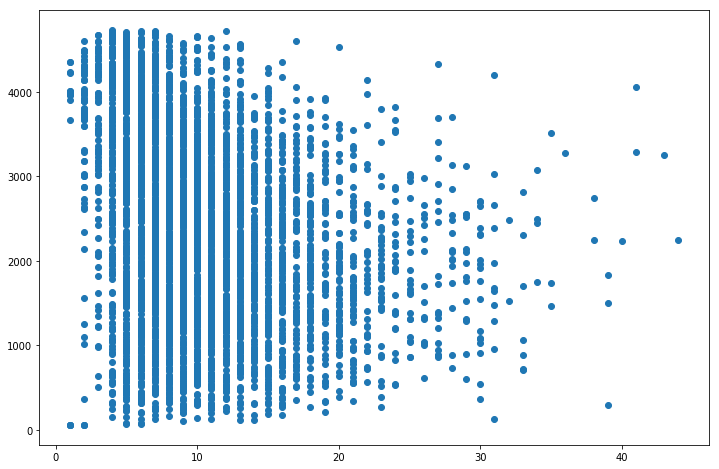

In [29]:
import matplotlib.pyplot

length = []
avg_rank = []
for pid in persp_rank.keys():
    if pid in persp_tok_length:
        avg_rank.append(persp_rank[pid])
        length.append(persp_tok_length[pid])

figsize=(12, 8)

fig = matplotlib.pyplot.figure(figsize=figsize)
matplotlib.pyplot.scatter(length,avg_rank)
matplotlib.pyplot.show()

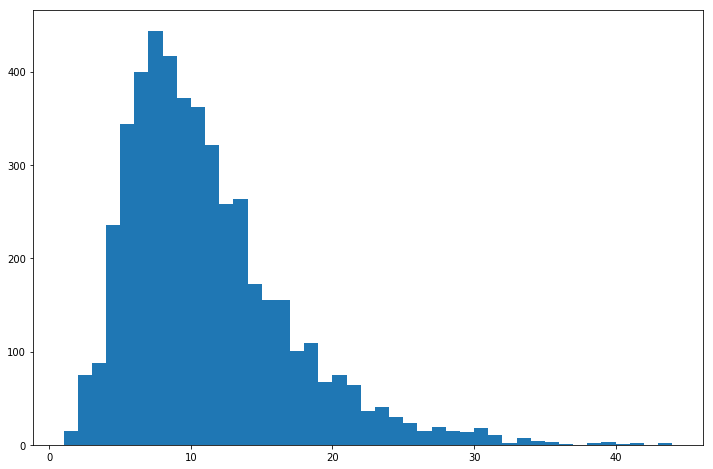

In [36]:
p_l = persp_tok_length.values()

figsize=(12, 8)

fig = matplotlib.pyplot.figure(figsize=figsize)

matplotlib.pyplot.hist(p_l, range=[0, 40], bins=range(min(p_l), max(p_l) + 1, 1))
matplotlib.pyplot.show()

NameError: name 'Counter' is not defined